Reporting consists of developing final data tables and figures to show the trends or progresses in Tb cases and outcomes. Final data tables can be created by using similar operations like data processing and transformation. Python also provides many packages for data visualization. This notebook uses matplotlib, a very popular library that is widely used for figures and is also used as backend for various other visualization packages and tools.  

To run this notebook, we require pandas and duckdb for reading and preparing data for reports and matplotlib to visualize charts. `pyplot` is matplotlib's interface to displaying figures on the screen.

In [61]:
import pandas as pd
import duckdb
import matplotlib.pyplot as plt

As shown previously, pandas API supports reading multiple data sources. Here we read the parquet files that contain TB case and outcome data in the common format, but Pandas can also support excel, csv or other types.

In [62]:
cases=pd.read_parquet("tests/CaseFileOutput")
outcomes = pd.read_parquet("tests/OutcomeFileOutput/")

In [63]:
cases.head(5)

,RegisterCaseNumber,Subject_Code,ReportingProvince,Date_Of_Birth,Gender,Age,AgeGroup,City,Health_Unit,PostalCode,...,PrevAbnormalChestXRay,Diabetes,LTCorticosteroidUse,LiveCorrectionSetting,Homeless,TravelTBCountry,OtherRiskFactors,Howlong,Case_Comment,Survey_Year
0,1,2013-1,British Columbia,9999/99/99,F,61,8,,,Z9Z,...,2,1,1,,9,,tobacco use,,"Here's looking at you, kid.",2013
1,25,2013-25,British Columbia,9999/99/99,None,19,4,,,Z9Z,...,1,9,2,,2,,tobacco use,,Ask not what your country can do for you; ask ...,2013
2,26,2013-26,British Columbia,9999/99/99,None,35,6,,,Z9Z,...,9,9,2,,9,,alcohol and tobacco use,,Those who refuse to learn from history are con...,2013
3,32,2013-32,British Columbia,9999/99/99,F,18,4,,,Z9Z,...,9,9,2,,2,,None,,Mama always said life was like a box of chocol...,2013
4,36,2013-36,British Columbia,9999/99/99,M,17,4,,,Z9Z,...,9,1,9,,2,,None,,A census taker once tried to test me. I ate hi...,2013


In [64]:
outcomes.head(5)

,TBPC_NUMBER,DiagnosisDate_2,IfTransfer_2,Re_RegisterCaseNume_2,Re_UniqueID_2,NoTreatmentRecvd,InitTreatDate_2,LastDayOfTreatment_2,ACQUIRED_RESISTANCE,AR_INH,...,Casual_ActiveTB,Casual_LTBI,Casual_BeginningTrt,Casual_CompletingTrt,Community_ContactEvaluated,Community_ActiveTB,Community_LTBI,Community_BeginningTrt,Community_CompletingTrt,outcome_surveyyear
0,,2013-05-17,,15,,,2000-09-30,2015-04-21,,,...,,,,,,,,,,2013
1,,2013-02-24,,31,,,2003-10-16,2007-11-20,,,...,,,,,,,,,,2013
2,,2013-09-14,,36,,,1995-07-26,2017-05-09,,,...,,,,,,,,,,2013
3,,2013-07-20,,37,,,2000-07-09,2008-07-12,,,...,,,,,,,,,,2013
4,,2013-01-01,,52,,,2000-01-23,2008-11-18,,,...,,,,,,,,,,2013


#### Creating charts using matplotlib

We explore some examples for visualizing charts using matplotlib.  

For the first sample, we visualize the number of TB cases per year in each province with a bar chart. This requires dividing the data into groups that have the same year and provinces. The count of cases in each division can be displayed using a bar graph.

In [67]:
VIZ_QUERY= """
    SELECT 
        REPORTINGPROVINCE as province,
        SURVEY_YEAR as year,
        COUNT(1) as n
    FROM cases
    GROUP BY REPORTINGPROVINCE, SURVEY_YEAR
    ORDER BY SURVEY_YEAR
"""

bar_graph = duckdb.sql(VIZ_QUERY).to_df()
bar_graph

,province,year,n
0,British Columbia,2013,91
1,British Columbia,2014,92
2,British Columbia,2015,94
3,British Columbia,2016,97
4,British Columbia,2017,98
5,British Columbia,2018,74
6,British Columbia,2019,78
7,British Columbia,2020,109
8,British Columbia,2021,90
9,British Columbia,2022,70


`pyplot` provides the `bar` method that displays the graph. Since we need the bar to represent the number of cases, height is set to the array containing all `n` and the individual x-axis marks are set to a list created by appending province and year. `pyplot` also helps configure other metadata to display like Labels for the axes, titles and ticks.

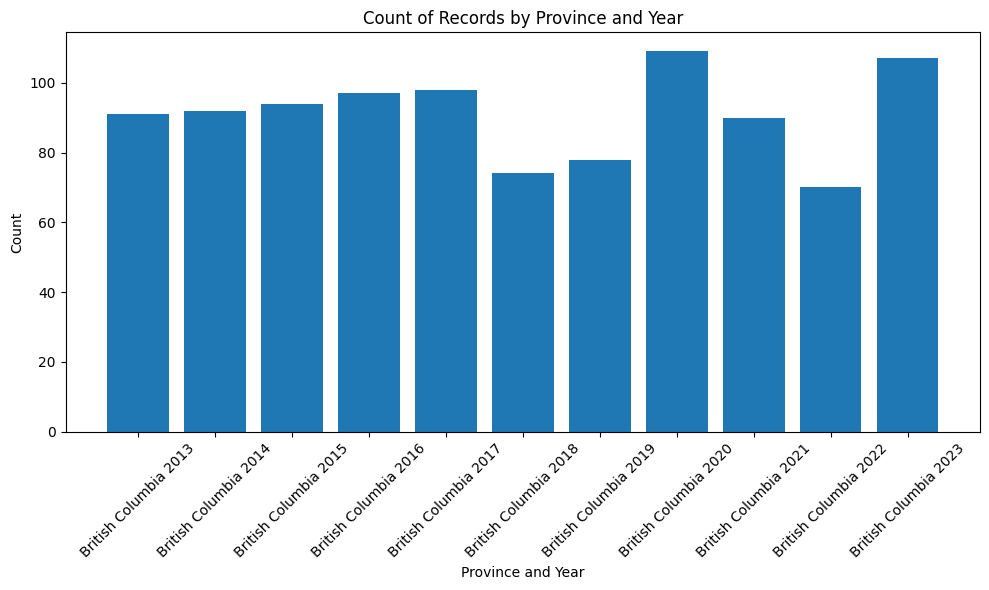

In [69]:
plt.figure(figsize=(10, 6))
plt.bar(x=bar_graph['province'] + ' ' + bar_graph['year'].astype(str), height=bar_graph['n'])
plt.xlabel('Province and Year')
plt.ylabel('Count')
plt.title('Count of Records by Province and Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

To report on how cases were detected for the record, the field `CaseFinding` which is mapped based on numeric classifications have to be converted back to string values that is understable to us. 

In [72]:
CASE_DETECTION_QUERY="""SELECT *, CASE
        WHEN CaseFinding IN (1, 2) THEN '1-Symptoms or Incidental'
        WHEN CaseFinding IN (5, 5.1, 5.2) THEN '2-Immigration'
        WHEN CaseFinding = 4 THEN '3-Contact Investigation'
        WHEN CaseFinding = 3 THEN '4-Post mortem'
        WHEN CaseFinding = 7 THEN '5-Occupational Screening'
        WHEN CaseFinding = 8 THEN '6-Other screening'
        WHEN CaseFinding = 9 THEN '7-Other Specify'
        ELSE NULL
    END 
    as case_detection
FROM cases"""
new_df = duckdb.sql(CASE_DETECTION_QUERY).to_df()
new_df[['CaseFinding', 'case_detection']].head()

,CaseFinding,case_detection
0,9.0,7-Other Specify
1,3.0,4-Post mortem
2,NaN,None
3,NaN,None
4,2.0,1-Symptoms or Incidental


In [80]:
CASE_DETECTION_TRENDS_QUERY = """
    SELECT
        Survey_Year as year,
        case_detection,
        count(1) as n
    FROM
        new_df
    GROUP BY 
        Survey_Year, case_detection
    ORDER BY
        Survey_Year
"""
trends_case_detection = duckdb.sql(CASE_DETECTION_TRENDS_QUERY).to_df()
trends_case_detection.head(10)

,year,case_detection,n
0,2013,4-Post mortem,10
1,2013,1-Symptoms or Incidental,23
2,2013,2-Immigration,5
3,2013,7-Other Specify,13
4,2013,None,40
5,2014,2-Immigration,12
6,2014,None,39
7,2014,7-Other Specify,8
8,2014,1-Symptoms or Incidental,22
9,2014,4-Post mortem,11


The dataframe `trends_case_detection` consists of the yearwise number of each case detection numbers. One possible way of showing the yearwise trend of one specific type of case_detection method, say, "*4-Post mortem*", would be through a line chart. To do this, we first filter the records containing this specific case_detection value and then use the plot method that by default generates a line chart. Once again, we re-use the methods to display metadata. `legend()` can be used to display keys for each marker used. 

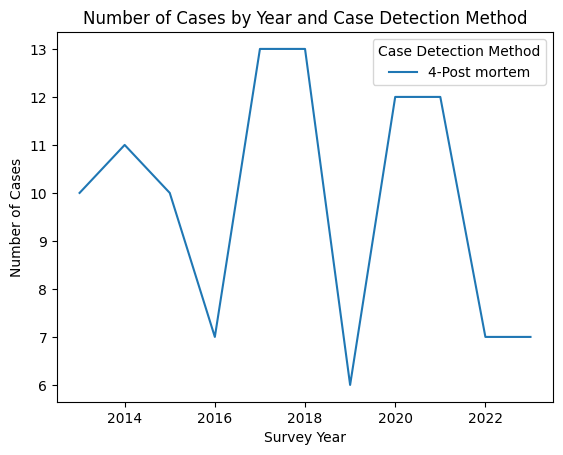

In [87]:
plot_data = trends_case_detection[trends_case_detection['case_detection'] == '4-Post mortem']
plt.plot(plot_data["year"], plot_data["n"], label="4-Post mortem")
plt.xlabel('Survey Year')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Year and Case Detection Method')
plt.legend(title='Case Detection Method')
plt.show()

There are other case_detection methods that can be plotted using lines. For this, we need all case_detection values. Using column name indices of Dataframes returns an object of a type known as [`numpy`](https://numpy.org/doc/stable/) array. These arrays provide a method called [`unique`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html) that returns all unique values in such arrays. All the new markers will be added to the legend with the same method above.

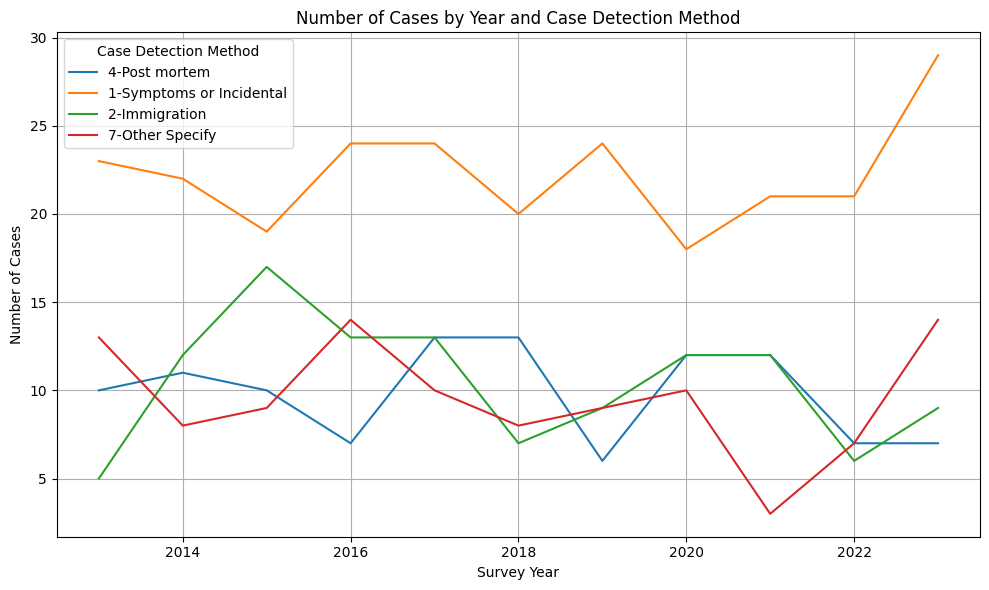

In [89]:
plt.figure(figsize=(10, 6))

for method in trends_case_detection['case_detection'].unique():
    data = trends_case_detection[trends_case_detection['case_detection'] == method]
    plt.plot(data['year'], data['n'], label=method)

plt.xlabel('Survey Year')
plt.ylabel('Number of Cases')
plt.title('Number of Cases by Year and Case Detection Method')
plt.legend(title='Case Detection Method')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Creating Data tables for reports:  

Data tables can be created using SQL query strings and DuckDB like the transformations seen earlier. Lets construct a data table for teh number and rate of treatment outcomes. For this example, there are 3 possible outcomes assumed for TB cases.

In [ ]:
SQL_QUERY="""
SELECT
    outcome_surveyyear AS Year,
    SUM(CASE WHEN TreatmentOutcome_2 = 2 THEN 1 ELSE 0 END) AS Treatment_Successful_n,
    SUM(CASE WHEN TreatmentOutcome_2 = 3 THEN 1 ELSE 0 END) AS Deceased_n,
    SUM(CASE WHEN TreatmentOutcome_2 = 4 THEN 1 ELSE 0 END) AS Left_n,
    (SUM(CASE WHEN TreatmentOutcome_2 = 2 THEN 1 ELSE 0 END) / COUNT(*))*100 AS Treatment_Successful_rate,
    (SUM(CASE WHEN TreatmentOutcome_2 = 3 THEN 1 ELSE 0 END) / COUNT(*))*100 AS Deceased_n_rate,
    (SUM(CASE WHEN TreatmentOutcome_2 = 4 THEN 1 ELSE 0 END) / COUNT(*))*100 AS Left_rate,
    COUNT(*) AS TotalCases,
    
FROM
    outcomes where TreatmentOutcome_2 = 2 or TreatmentOutcome_2=3 or TreatmentOutcome_2=4
GROUP BY
    outcome_surveyyear
ORDER BY
    outcome_surveyyear;
"""
duckdb.sql(SQL_QUERY).to_df()

,Year,Treatment_Successful_n,Deceased_n,Left_n,Treatment_Successful_rate,Deceased_n_rate,Left_rate,TotalCases
0,2013,6.0,6.0,21.0,18.181818,18.181818,63.636364,33
1,2014,6.0,3.0,13.0,27.272727,13.636364,59.090909,22
2,2015,9.0,7.0,15.0,29.032258,22.580645,48.387097,31
3,2016,8.0,5.0,21.0,23.529412,14.705882,61.764706,34
4,2017,4.0,4.0,13.0,19.047619,19.047619,61.904762,21
5,2018,3.0,8.0,15.0,11.538462,30.769231,57.692308,26
6,2019,6.0,9.0,13.0,21.428571,32.142857,46.428571,28
7,2020,5.0,11.0,24.0,12.500000,27.500000,60.000000,40
8,2021,10.0,5.0,13.0,35.714286,17.857143,46.428571,28
9,2022,14.0,4.0,18.0,38.888889,11.111111,50.000000,36
